# Miniproyecto 1: Detección de globulos blancos

# Entrega 2:

Para poder desarrollar el mejor algoritmo de detección, y en general de cualquier problema de vision por computador, debemos desarrollar un método de evaluación pertinente para determinar numericamente cuál modelo es mejor que otros. La evaluación cualitativa carece de sentido en bases de datos grandes o en modelos que realicen predicciones muy similares, recuerden que queremos obtener el mejor modelo posible implementando las herramientas que tenemos a mano.

### Parte 1: Calculo de precisión y cobertura

La precisión y cobertura es una metodologia de evaluación clasica para los problemas de detección, nos indica que tan segura es la predicción de nuestro modelo y cuan probable es que nuestro modelo logre abarcar a todos los verdaderos positivos. En un problema de detección, que es en esencia un problema de clasificación por ventanas, necesitamos tener un criterio para determinar cuando una ventana se considera positiva o negativa con respecto a la anotación. 

#### 1.1 Comparación de anotaciones y predicciones:

En esta ocasion, les entregamos unas anotaciones para que logren calcular las metricas de evaluación, en un futuro desarrollarán un modelo para la detección de globulos blancos y utilizarán las funciones implementadas en este laboratorio.

Nuestras anotaciones son diccionarios cuya llave "bbox" son 4 valores enteros [X,Y,W,H] donde (X,Y) son las coordenadas de la esquina superior izquierda y W,H son el ancho y el alto de la bounding box. Primero, vamos a crear la mascara binaria de la caja de la predicción o anotación. Crearemos una función que entre como parametros los 4 valores enteros, y retorne una mascara binaria para la anotación y para la predicción.

> - Construya la caja teniendo en cuenta que las coordenadas proporcionadas son la coordenada **X** e **Y** de la esquina superior izquierda, y la altura y base de la caja respectivamente. Convierta en enteros las coordenadas.
> - Establezca el tamaño de la ventana como 500x500.
> - Puede hacer una matriz de zeros con el tamaño deseado y luego reemplazar los valores en los puntos que encierra.

In [1]:
import numpy as np
def bounding_box(X,Y,W,H):
    # YOUR CODE HERE
    A = np.zeros((500, 500))
    x1, y1, x2, y2 = int(X), int(Y), int(X+W), int(Y+H)
    A[y1:y2, x1:x2] = 1

    return A

Pruebe su función con el primer elemento de sus anotaciones de valid y el primer elemento de las predicciones del archivo dummy_predictions.json. Haga un plot con ambas mascaras binarias.

C:\Users\eduar\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


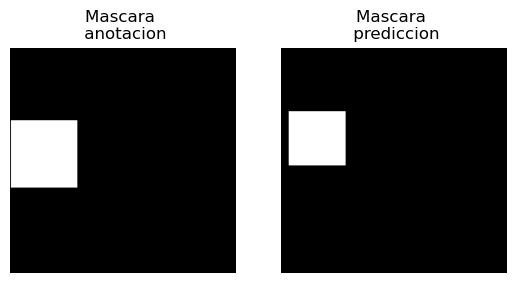

In [2]:
import json
import os
from matplotlib import pyplot as plt
from skimage import io

prediccion='' # archivo .json de las predicciones
anotaciones='' # archivo .json de las anotaciones

Ax,Ay,Aw,Ah='','','','' # coordenadas de la bbox de la anotación
Px,Py,Pw,Ph='','','','' # coordenadas de la bbox de la predicción

A='' # mascara binaria de la anotación
P='' # mascara binaria de la predicción

# YOUR CODE HERE
# carga de los diccionarios
anotaciones_file= open(os.path.join(".","data_mp1","BCCD","valid","_annotations.coco.json"))
anotaciones= json.load(anotaciones_file)
anotaciones_file.close()

prediccion_file= open(os.path.join(".","data_mp1","dummy_predictions.json"))
prediccion = json.load(prediccion_file)
prediccion_file.close()

Ax,Ay,Aw,Ah = anotaciones['annotations'][0]['bbox']
Px,Py,Pw,Ph = prediccion[0]['bbox']

A = bounding_box(Ax,Ay,Aw,Ah)
P = bounding_box(Px,Py,Pw,Ph)

# graficar
fig, ax = plt.subplots(1,2)#filas,#columnas
ax[0].set_title('Mascara \n anotacion')
ax[1].set_title('Mascara \n prediccion')
ax[0].axis("off")
ax[0].imshow(A, cmap='gray')
ax[1].axis("off")
ax[1].imshow(P, cmap='gray')
plt.show()

In [3]:
assert (A.shape[0]==500), f'El tamaño de la mascara binaria debería ser 500x500 y es {A.shape}'
assert (A.shape[1]==500), f'El tamaño de la mascara binaria debería ser 500x500 y es {A.shape}'
assert (np.isclose(np.sum(A),Aw*Ah,0.1)), f'El area de la bbox de la anotación debería ser igual a la multiplicación de el ancho y el alto de la bbox'
assert (P.shape[0]==500), f'El tamaño de la mascara binaria debería ser 500x500 y es {P.shape}'
assert (P.shape[1]==500), f'El tamaño de la mascara binaria debería ser 500x500 y es {P.shape}'
assert (np.isclose(np.sum(P),Pw*Ph,0.1)), f'El area de la bbox de la predicción debería ser igual a la multiplicación de el ancho y el alto de la bbox'
assert (np.isclose(np.sum(A*P),12600,0.1))

#### 1.2 Determinación de verdaderos positivos, falsos positivos y falsos negativos por umbral:

Para poder determinar que predicciones consideramos positivas o negativas, debemos determinar que tanto se "parecen" las predicciones a las anotaciones y que tanto podemos confiar en estas predicciones. Antes que nada, debemos determinar cual va a ser nuestra minima confianza en nuestra predicción, de nada sirve un modelo que genera predicciones sin seguridad. Por otro lado, una metodologia para calcular esta similitud es el indice de Jaccard. Primero, estableceremos un umbral de confianza, si la predicción tiene la suficiente confianza se pasa a calcular la similitud de la prediccion-anotación. Ahora que tenemos una función que retorna una mascara binaria para la predicción y anotación, utilizaremos la función del indice de Jaccard **implementada en el tutorial 1** para determinar la similitud entre predicción-anotación.

Cree una función que entre como parametro el diccionario de predicción y el de anotación junto con un umbral de jaccard y un umbral de confianza (no son lo mismo). Esta función retorna un numpy array de 3 componentes, la primera es el verdadero positivo, la segunda es falso positivo y la tercera es falso negativo. De esta forma, si la prediccion es un falso positivo, retorna un [0,1,0]. Recuerde que si la confianza de la predicción es menor al umbral, se considera un falso negativo, esta no se tiene en cuenta.


> - Tenga cuidado de usar bien los umbrales, no utilice el umbral de Jaccard como confianza y viseversa.
> - El diccionario de la predicción tiene una llave "score" que indica la confianza de la predicción.
> - Use la función bounding_box para crear las mascaras binarias.

In [4]:
def evaluacion(anotacion_dict,prediccion_dict,j_umbral,c_umbral):
    metricas='' # arreglo de metricas [TP,FP,FN]
    # YOUR CODE HERE
    metricas = [0,0,0]
    Ax,Ay,Aw,Ah = anotacion_dict['bbox']
    Px,Py,Pw,Ph = prediccion_dict['bbox']
    A = bounding_box(Ax,Ay,Aw,Ah)
    P = bounding_box(Px,Py,Pw,Ph)
    
    # verificar que el score de la prediccion sea mayor al c_umbral
    score = prediccion_dict['score']
    if score < c_umbral:
        metricas[2] += 1  # FN 
    else:
        # verificar que el indice de Jaccard sea superior al umbral
        jaccard_index = jaccard(A, P) 
        if jaccard_index > j_umbral:
            metricas[0] += 1 # TP
        else:
            metricas[1] += 1 # FP
            metricas[2] += 1 # FN

    return metricas    

def jaccard(mask1,mask2):
    # YOUR CODE HERE
    inter = np.sum ( np.logical_and(mask1, mask2) )
    union = np.sum( np.logical_or(mask1, mask2) )
    return inter / union

In [5]:
[TP1,FP1,FN1]=evaluacion(anotaciones["annotations"][3],prediccion[3],0.5,0.7)
[TP2,FP2,FN2]=evaluacion(anotaciones["annotations"][1],prediccion[1],0.5,0.7)
[TP3,FP3,FN3]=evaluacion(anotaciones["annotations"][0],prediccion[0],0.5,0.7)

assert (FN1==1), 'Esta prediccion debería ser un Falso Negativo'
assert (TP3==1), 'Esta prediccion debería ser un Verdadero Positivo'
assert (FN2==1), 'Esta prediccion debería ser un Falso Negativo'
assert (FP2==1), 'Esta prediccion debería ser un Falso Positivo'

#### 1.3 Metricas:

Haga una función que entre como parametro los .json de las anotaciones y predicciones junto con un umbral de jaccard y confianza. Debe retornar la precisión, cobertura y F medida de la base de datos. Recuerde que hay multiples detecciones por imagen, así que queremos quedarnos unicamente con las detecciones de la categoria 3, que corresponde a los globulos blancos.

Recuerde que la formula de Precisión, Cobertura y F medida son las siguientes:

\begin{equation}
P = \frac{TP}{TP+FP+\epsilon}
\end{equation}

\begin{equation}
C = \frac{TP}{TP + FN+\epsilon}
\end{equation}

\begin{equation}
F_{medida} = \frac{2 (P \times C)}{P + C+\epsilon}
\end{equation}

El termino $\epsilon$ se agrega en la implementación del codigo como una constante pequeña (en nuestro caso dejela como $1 \times 10^{-6}$) para no afectar el calculo de las metricas pero evitar la division por 0.

In [6]:
def Metricas(anotaciones,predicciones,j_umbral,c_umbral):
    # YOUR CODE HERE
    
    epsilon = 1e-6
    TP, FP, FN = 0,0,0
    # hay una imagen que doble anotacion (39) y una imagen sin anotacion (63) 
    # hay una imagen con doble prediccion (39) y una imagen sin prediccion (63). Todas las predicciones son category 3
    for annotation in anotaciones['annotations']:
        if annotation['category_id'] == 3:
            for prediccion in predicciones:
                if annotation['image_id'] == prediccion['image_id']:
                    metricas = evaluacion(annotation, prediccion, j_umbral, c_umbral)
                    TP += metricas[0]
                    FP += metricas[1]
                    FN += metricas[2]
            
    P = TP / (TP+FP+epsilon)
    C = TP / (TP+FN+epsilon)
    F = 2*P*C / (P+C+epsilon)
    return P,C,F

In [7]:
P,C,F=Metricas(anotaciones,prediccion,0.5,0.7)

assert P>0 and P<1, 'La precisión no puede ser menor a 0 ni mayor a 1'
assert C>0 and C<1, 'La cobertura no puede ser menor a 0 ni mayor a 1'
assert F>0 and F<1, 'La F medida no puede ser menor a 0 ni mayor a 1'

assert P>C, 'La precisión debe ser mayor a la cobertura para esta predicción'
assert F>C and F<P, 'La F medida debe ser mayor a la precisión y mayor a la cobertura en esta predicción'
assert (np.isclose(P*C,0.328,0.1)), 'El valor de la precisión o la cobertura es erronea'

### Parte 2: Calculo de curvas de precisión y cobertura y mAP

#### 2.1 Curva de precisión y cobertura:
Cómo podemos determinar cuál modelo es mejor? Un modelo poseerá varias caracteristicas, no es tan simple como escoger la mejor precisión o la mejor cobertura, tampoco la mejor F medida, ya que esto dependerá del umbral de confianza escogido. Variaremos, entonces, el valor del umbral de confianza, este umbral nos proporcionará una precisión y una cobertura especifica, este será un punto en el plano Precisión,Cobertura, de esta forma crearemos una curva. 

Cree una función que varie el umbral de confianza desde 0.1 hasta 1 con 100 datos y genere la precisión, cobertura y F medida con ayuda de la función Metricas. Esta función recibe como parametro el .json de anotaciones y predicciones, y un umbral de Jaccard, y deberá retornar 2 vectores (P,C) de 10 posiciones (un dato por cada umbral).
> - Recuerde variar el umbral de confianza, no el de Jaccard.

Un aspecto importante de las métricas es la F medida, queremos encontrar cual es el valor máximo de F medida alcanzado y para cual umbral de confianza. Retornen tambien estos 2 valores en la función.

Grafique la curva de precisión y cobertura. Nosotros les graficaremos unas curvas de F medida, estas curvas son la combinación de precisión y cobertura que generan una F medida especifica. De esta forma, podemos ver graficamente cual es la F medida más alta alcanzada por nuestro modelo. 


In [8]:
def Curvas_P_C(anotaciones,predicciones,jaccard):
    # YOUR CODE HERE
    umbrales = np.linspace(0.1, 1, 100)
    Pr, Co, Fm = np.zeros(100), np.zeros(100), np.zeros(100)
    
    for i in range(len(umbrales)):
        P, C, F = Metricas(anotaciones, predicciones, jaccard, umbrales[i])
        Pr[i] = P
        Co[i] = C
        Fm[i] = F
    return Pr,Co,Fm,umbrales

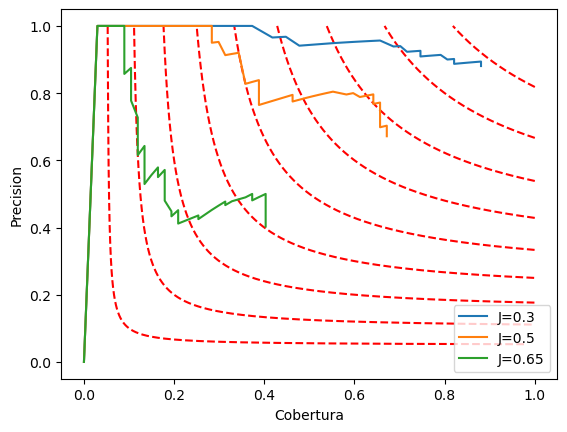

In [9]:
import numpy as np
from matplotlib import pyplot as plt
    
#Dibujamos las curvas de F medida
p=np.arange(0.0001,1.0001,0.0001)
for f in np.arange(0.0,1.2,0.1): #saltos de 0.1 desde una F medida de 0 hasta una F medida de 1
    aux=np.zeros(len(p))
    for i in range(len(p)):
        k=(2*p[i]-f)
        if k>0.001:
            c=f*p[i]/k
            aux[i]=c
    c=np.copy(aux)
    c=c*(c<=1)
    l2=np.where(c!=0)[0]
    C=c[l2]
    P=p[l2]
    plt.plot(C,P,'r--')
Pr1,Co1,F1,umbral1=Curvas_P_C(anotaciones,prediccion,0.4)
Pr2,Co2,F2,umbral2=Curvas_P_C(anotaciones,prediccion,0.55)
Pr3,Co3,F3,umbral3=Curvas_P_C(anotaciones,prediccion,0.65)
plt.plot(Co1,Pr1,label='J=0.3')
plt.plot(Co2,Pr2,label='J=0.5')
plt.plot(Co3,Pr3,label='J=0.65')
plt.xlabel('Cobertura')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [10]:
assert (len(Pr1)==100)
assert (len(Co1)==100)
assert (len(Pr2)==100)
assert (len(Co2)==100)
assert (len(Pr3)==100)
assert (len(Co3)==100)
assert (1 in np.isclose(np.around(Pr1,4),np.ones(100)*0.8906,0.01))
assert (1 in np.isclose(np.around(Pr2,4),np.ones(100)*0.6818,0.01))

#### 2.2 Calcular mAP

Una metrica importante del desempeño del modelo es el mAP, que es, en esencia, el area bajo la curva de la curva de precisión y cobertura. Obtenga el area bajo la curva del modelo. El calculo de esta metrica se encuentra acontinuación.

In [11]:
def mAP(precision,cobertura):
    'precisión: Arreglo de precisión'
    'cobertura: Arreglo de cobertura'
    A=0
    for i in range(len(cobertura)-1):
        A+=(cobertura[i]-cobertura[i+1])*precision[i]
    return A


Encuentre el mejor umbral de Jaccard para su modelo con el mayor umbral de confianza posible. Use la siguiente celda para graficar la curva de precisión y cobertura e imprimir el mAP. Haga al menos 5 experimentos.

Probamos 25 combinaciones variando el umbral de confianza y el umbral de Jaccard (tomamos 5 valores equidistantes entre 0.1 y 1 para cada umbral):

Combinacion 1: confianza=0.1, Jaccard=0.1, F=0.97
Combinacion 2: confianza=0.1, Jaccard=0.3, F=0.925
Combinacion 3: confianza=0.1, Jaccard=0.5, F=0.746
Combinacion 4: confianza=0.1, Jaccard=0.7, F=0.239
Combinacion 5: confianza=0.1, Jaccard=0.9, F=0.03
Combinacion 6: confianza=0.3, Jaccard=0.1, F=0.922
Combinacion 7: confianza=0.3, Jaccard=0.3, F=0.891
Combinacion 8: confianza=0.3, Jaccard=0.5, F=0.75
Combinacion 9: confianza=0.3, Jaccard=0.7, F=0.25
Combinacion 10: confianza=0.3, Jaccard=0.9, F=0.031
Combinacion 11: confianza=0.5, Jaccard=0.1, F=0.796
Combinacion 12: confianza=0.5, Jaccard=0.3, F=0.796
Combinacion 13: confianza=0.5, Jaccard=0.5, F=0.726
Combinacion 14: confianza=0.5, Jaccard=0.7, F=0.265
Combinacion 15: confianza=0.5, Jaccard=0.9, F=0.035
Combinacion 16: confianza=0.7, Jaccard=0.1, F=0.527
Combinacion 17: confianza=0.7, Ja

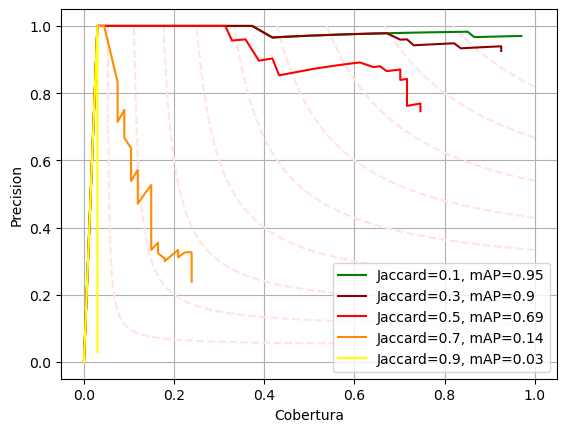

In [12]:
# YOUR CODE HERE
umbrales_confianza = np.linspace(0.1, 0.9, 5)
umbrales_jaccard = np.linspace(0.1, 0.9, 5)
F_max, c_optimo, j_optimo  = 0,0,0

# Probamos varias combinaciones de umbrales de confianza y de jaccard,  y se elige la que de un mayor F:
print('Probamos 25 combinaciones variando el umbral de confianza y el umbral de Jaccard'
      ' (tomamos 5 valores equidistantes entre 0.1 y 1 para cada umbral):\n')
i = 1
for umbral_c in umbrales_confianza:
    for umbral_j in umbrales_jaccard:
        P, C, F = Metricas(anotaciones, prediccion, umbral_j, umbral_c)
        print(f'Combinacion {i}: confianza={round(umbral_c,3)}, Jaccard={round(umbral_j,3)}, F={round(F,3)}')
        i += 1
        if F > F_max:
            F_max = F
            c_optimo = umbral_c
            j_optimo = umbral_j
print('\nElegimos la combinacion con mayor F-medida:')
print(f'La mayor F-medida fue de {round(F_max,3)} para un umbral de confianza de {c_optimo}, y un indice de Jaccard de {j_optimo}')

print('\nPor ultimo, graficamos las curvas de precision y cobertura, y encontramos su mAP')
print('En verde se encuentra la combinación optima:')
#Dibujamos las curvas de F medida
p=np.arange(0.0001,1.0001,0.0001)
for f in np.arange(0.0,1.2,0.1): #saltos de 0.1 desde una F medida de 0 hasta una F medida de 1
    aux=np.zeros(len(p))
    for i in range(len(p)):
        k=(2*p[i]-f)
        if k>0.001:
            c=f*p[i]/k
            aux[i]=c
    c=np.copy(aux)
    c=c*(c<=1)
    l2=np.where(c!=0)[0]
    C=c[l2]
    P=p[l2]
    plt.plot(C,P, color='mistyrose', linestyle='dashed')    


Pr, Co, _, _ = Curvas_P_C(anotaciones,prediccion,j_optimo) # optimo
Pr1, Co1, _, _ = Curvas_P_C(anotaciones,prediccion,umbrales_jaccard[1])
Pr2, Co2, _, _ = Curvas_P_C(anotaciones,prediccion,umbrales_jaccard[2])
Pr3, Co3, _, _ = Curvas_P_C(anotaciones,prediccion,umbrales_jaccard[3])
Pr4, Co4, _, _ = Curvas_P_C(anotaciones,prediccion,umbrales_jaccard[4])

plt.plot(Co,Pr,label=f'Jaccard={j_optimo}, mAP={round(mAP(Pr, Co),2)}',color='green') # optimo
plt.plot(Co1,Pr1,label=f'Jaccard={round(umbrales_jaccard[1],1)}, mAP={round(mAP(Pr1, Co1),2)}', color='darkred')
plt.plot(Co2,Pr2,label=f'Jaccard={round(umbrales_jaccard[2],1)}, mAP={round(mAP(Pr2, Co2),2)}', color='red')
plt.plot(Co3,Pr3,label=f'Jaccard={round(umbrales_jaccard[3],1)}, mAP={round(mAP(Pr3, Co3),2)}', color='darkorange')
plt.plot(Co4,Pr4,label=f'Jaccard={round(umbrales_jaccard[4],1)}, mAP={round(mAP(Pr4, Co4),2)}', color='yellow')

plt.xlabel('Cobertura')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()

### Parte 3: Detección mediante segmentación
La metodología que usaremos para detectar un globulo blanco será a partir de una mascara de segmentación, la idea será crear un recuadro al rededor de la segmentación del globulo. Existen varias metodologías para resolver este problema, nosotros experimentaremos con 2 de ellas, una grilla y una ventana deslizante.

#### 3.1: Grilla
Las imagenes son, en esencia, grillas de pixeles. La idea general de esta metodología será crear cuadrantes dentro de nuestra mascara binaria y clasificar los cuadrantes como positivos o negativos según la cantidad de pixeles True dentro de estos, esto significa que debemos determinar un umbral de area dentro del recuadro y el tamaño o cantidad de recuadros.

Cree una función que reciba por parametro una mascara binaria, tamaño del cuadrante (filas, columnas) y el umbral de area. Debe retornar una tupla (X,Y,W,H).

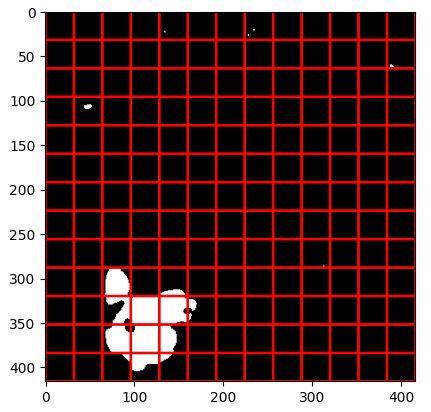

> - Solo debe retornar el la detección con mayor area.
> - Debe comprobar que el tamaño del cuadrante sea entero y que el tamaño de la mascara binaria sea divisible en el tamaño del cuadrante (para evitar tener cuadrantes a medias)
> - Una forma simple de saber cuantos Trues existen en un arreglo es usar np.sum() ya que python considera los True como 1s.
> - En esta metodología, el ancho y el alto de la bbox son constantes, el tamaño del cuadrante
> - Si ningun cuadrante sobrepasan el umbral, retorne 4 None.

In [13]:
from skimage import io
import os
import numpy as np

def Grilla(mask,tamano,umbral):
    'mask (ndarray): Mascara binaria'
    'tamano (tupla): Tamaño en filas,columnas del cuadrante'
    'umbral (int): cantidad de True para determinar positivo'
    # YOUR CODE HERE
    
    # Verificar que el tamaño del cuadrante sea entero
    if not isinstance(tamano[0], int) or not isinstance(tamano[1], int):
        raise Exception('El tamano debe ser entero')
        
    # Verificar que el tamaño de la mascara binaria sea divisible en el tamaño del cuadrante 
    if (mask.shape[0] % tamano[0] != 0) or (mask.shape[1] % tamano[1] != 0):
        raise Exception('El tamano de la mascara debe ser divsible en el tamanio del cuadrante')
    
    alto, ancho = tamano
    ventanas_y = mask.shape[0] // alto
    ventanas_x = mask.shape[1] // ancho
    pixeles_maximo = 0
    X, Y, W, H = None, None, None, None
    
    for i in range(ventanas_y):
        for j in range(ventanas_x):
            ventana = mask[i*alto:(i+1)*alto, j*ancho:(j+1)*ancho]
            pixeles_detectados = np.sum(ventana)
            if (pixeles_detectados > umbral) and (pixeles_detectados > pixeles_maximo):
                pixeles_maximo = pixeles_detectados
                X = j*ancho
                Y = i*alto
                W = ancho
                H = alto
    
    return X,Y,W,H

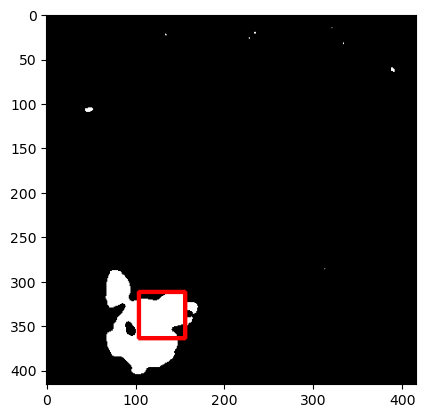

In [14]:
import cv2

mask=io.imread(os.path.join('data_mp1','dummy_segmentation.png'))!=0
X,Y,W,H=Grilla(mask,(52,52),1000)

assert W is not None, 'Ninguna coordenada deberia ser None'
assert W==52 and H==52, 'El alto y ancho de su bbox deben ser iguales al tamaño del cuadrante'
assert (np.sum(mask[Y:Y+W,X:X+H])!=0), 'Su detección no cuenta con ningun elemento'
assert (np.sum(mask[Y:Y+W,X:X+H])>1000), 'El area de la mascara de su detección es mayor al umbral'

plt.imshow(cv2.rectangle(np.array(np.stack((mask,mask,mask),axis=2),dtype=int)*255,(X,Y),(X+W,Y+H),(255,0,0),3))
plt.show()

assert np.isclose(Y,312,0.1), 'La coordenada en X es erronea'
assert np.isclose(X,104,0.1), 'La coordenada en Y es erronea'

X,Y,W,H=Grilla(mask,(52,52),2500)

assert X is None and Y is None, 'Debe retornar un None si el area no supera el umbral'

#### 3.2 Ventana deslizante:
Podemos observar que la detección de la celula blanca no es la mejor, la metodología de la grilla tiene problemas evidentes. Una evolución sería utilizar una ventana deslizante. En esta ocasión, volveremos a hacer un analisis local en una porción de la mascara, pero permitiremos un mayor numero de ventanas y, por lo tanto, una mayor probabilidad de tener una detección correcta.

Cree una función que reciba por parametro la mascara binaria, el tamaño de la ventana de analisis y un umbral. Haga el mismo procedimiento de la anterior función. Haga que el movimiento de la ventana sea cada 5 pixeles. 

> - Tenga cuidado de que la ventana deslizante no se salga de la imagen.
> - La metodología de la grilla es el mismo de la ventana deslizante pero con un movimiento de ventana igual al tamaño de la misma.

In [15]:
def Ventana_deslizante(mask,tamano,umbral):
    'mask (ndarray): Mascara binaria'
    'tamano (tupla): Tamaño en filas,columnas del cuadrante'
    'umbral (int): cantidad de True para determinar positivo'
    # YOUR CODE HERE

    alto, ancho = tamano
    pixeles_maximo = 0
    X, Y, W, H = None, None, None, None
    
    salto = 5
    ventanas_y = ventanas_y = (mask.shape[0] - alto) // salto
    ventanas_x = (mask.shape[1] - ancho) // salto
    
    for i in range(ventanas_y):
        for j in range(ventanas_x):
            ventana = mask[i*salto:i*salto+alto, j*salto:j*salto+ancho]
            pixeles_detectados = np.sum(ventana)
            if (pixeles_detectados > umbral) and (pixeles_detectados > pixeles_maximo):
                pixeles_maximo = pixeles_detectados
                X = j*salto
                Y = i*salto
                W = ancho
                H = alto

    return X,Y,W,H

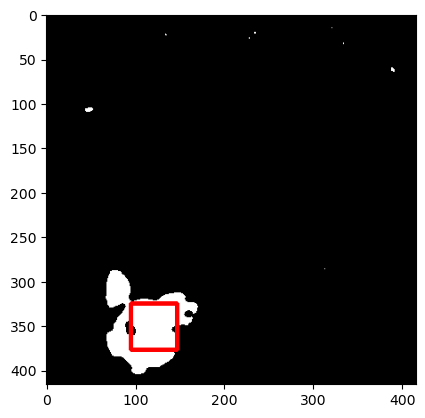

In [16]:
mask=io.imread(os.path.join('data_mp1','dummy_segmentation.png'))!=0
X,Y,W,H=Ventana_delizante(mask,(52,52),1000)

assert W is not None, 'Ninguna coordenada deberia ser None'
assert W==52 and H==52, 'El alto y ancho de su bbox deben ser iguales al tamaño del cuadrante'
assert (np.sum(mask[Y:Y+W,X:X+H])!=0), 'Su detección no cuenta con ningun elemento'
assert (np.sum(mask[Y:Y+W,X:X+H])>1000), 'El area de la mascara de su detección es mayor al umbral'

plt.imshow(cv2.rectangle(np.array(np.stack((mask,mask,mask),axis=2),dtype=int)*255,(X,Y),(X+W,Y+H),(255,0,0),3))
plt.show()

assert X%52!=0, 'No usó una ventana deslizante'
assert Y%52!=0, 'No usó una ventana deslizante'
assert np.isclose(Y,325,0.01), 'La coordenada en X es erronea'
assert np.isclose(X,95,0.005), 'La coordenada en Y es erronea'

X,Y,W,H=Grilla(mask,(52,52),2500)

assert X is None and Y is None, 'Debe retornar un None si el area no supera el umbral'

## Informe

Una vez realizada la parte practica de la metodología es necesario poder comprender mas allá de lo que realizamos anteriormente. Para esto deben responder las siguientes preguntas en su informe.

### Parte 1: Calculo de precisión y cobertura

Un problema de detección es, en esencia, un problema de clasificación por ventanas, por lo que podemos utilizar las mismas métricas de clasificación pero con ligeras modificaciones. En ese sentido conteste las siguientes preguntas:

- Explique con sus palabras como se determina un falso positivo y un falso negativo en un problema de detección y la razón detras de este.
- En este problema ¿Es preferible una alta precisión o una alta cobertura?


### Parte 2: Calculo de curvas de precisión y cobertura y mAP

La curva de precisión y cobertura es una metodología de evaluación que nos permite determinar la eficiencia de nuestro modelo de detección. Es importante conocer las caracteristicas de nuestro modelo y para que determinados momentos funciona mejor o peor. Teniendo eso en cuenta conteste las siguientes preguntas: 

- ¿A que parametro es sensible la curva de precisión y cobertura y por que?
- ¿En cual umbral de jaccard se obtuvo una mayor F medida?
- ¿Es preferible tener un umbral de Jaccard alto o bajo? ¿Cuales son sus ventajas y desventajas?
- ¿Que implica tener la maxima F medida en un bajo umbral de confianza? 
- Determine una metodología para obtener el mejor umbral de Jaccard sin comprometer la generalización del model

### Parte 3: Detección mediante segmentación

Una forma efectiva para realizar una detección es, primero, realizar una segmentación para luego agregar una caja al rededor de la mascara. Esta metodología tiene sentido pero tambien tiene algunos problemas asociados. Responda las siguientes preguntas:

- ¿Cuales son los problemas mas importantes con cada metodología?
- ¿A que parametro es sensible ambas metodologías?
- ¿Que debemos cambiar si deseamos detectar más de un globulo blanco en una unica imagen?
- Proponga posibles mejoras para cada metodología.